In [44]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from imblearn.over_sampling import ADASYN 
import shap

import matplotlib.pyplot as plt

In [45]:
# Load processed data
df = pd.read_csv(r"C:\Users\u1158100\Documents\test\IQVIA_DS_China_GDG_Delisting\processed\eng_processed.csv")
df.head()

,_202305,atc_count,growth_rate,growth_rate_1y_vs_2y,growth_rate_2y_vs_3y,growth_rate_3y_vs_4y,growth_rate_6m,growth_rate_6m_vs_1y,mnflg_1,mnflg_2,...,city_now_bins_5,city_now_bins_6,city_now_bins_7,city_now_bins_8,city_now_bins_9,city_now_bins_10,city_now_bins_11,city_now_bins_12,city_now_bins_13,delist_tab
0,924433.2,459,-0.048847,-0.624074,0.694423,15.629655,-0.900799,-0.048350,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0.0,459,0.000000,0.000000,0.000000,-1.000000,143174.209000,0.000000,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.0,2990,0.000000,-0.778802,-0.355755,-0.266294,23.345076,-0.607143,0,1,...,0,0,0,0,0,0,0,0,1,0
3,412.0,2990,0.228018,-0.373210,-0.255837,-0.401537,2.995931,-0.103490,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,2990,0.000000,0.000000,-1.000000,-0.877778,143174.209000,0.000000,0,1,...,0,0,0,0,0,0,0,0,1,0


[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 40447, number of negative: 40492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 80939, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499722 -> initscore=-0.001112
[LightGBM] [Info] Start training from score -0.001112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

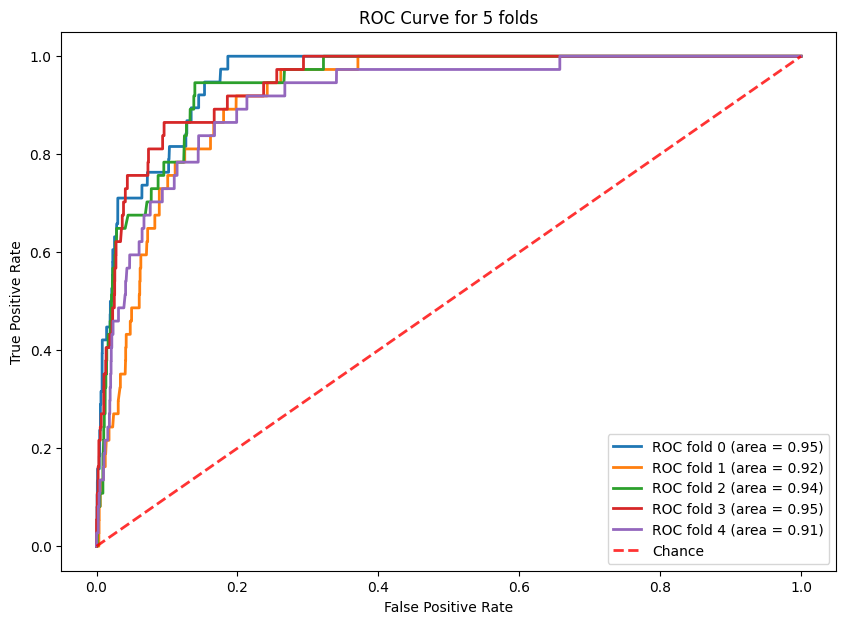

In [48]:
# Assuming you have your data in a DataFrame named df and target variable in a column named 'delist_tab'
X = df.drop('delist_tab', axis=1)
y = df['delist_tab'] 

# 1. 5-fold Cross Validation Split
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=816) 

# Placeholder for metrics and ROC values
precision_list = []
recall_list = []
f1_list = []
tpr_list = []  # true positive rate
fpr_list = []  # false positive rate
roc_auc_list = []
y_real = []
y_proba = [] 

# 2. Oversampling and 3. Train XGBoost
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 

    ada = ADASYN(random_state=42)
    X_train_res, y_train_res = ada.fit_resample(X_train, y_train) 

    model = lgb.LGBMClassifier(
    n_estimators=150, 
    max_depth=3, 
    learning_rate=0.07, 
    subsample=0.9, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric="logloss",
    gamma=1.0,
    min_child_weight=5.0,
    scale_pos_weight=1.3,
)
    model.fit(X_train_res, y_train_res) 

    # 4. Testing Error Metrics
    y_pred = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1) 

    # ROC values
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    roc_auc_list.append(roc_auc)
    y_real.append(y_test)
    y_proba.append(y_score)
    
# 5. Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(5):
    plt.plot(fpr_list[i], tpr_list[i], lw=2,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc_list[i]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5 folds')
plt.legend(loc="lower right")
plt.show() 

In [47]:
print("Precision is:\n" + '\n'.join(map(str, precision_list)))
print("recall is:\n" + '\n'.join(map(str, recall_list)))
print("f1 is:\n" + '\n'.join(map(str, f1_list)))

Precision is:
[0.99886058 0.05325444]
[0.99783884 0.03611738]
[0.99867644 0.07100592]
[0.99906938 0.05725971]
[0.99834625 0.04329897]
recall is:
[0.95258323 0.71052632]
[0.95781883 0.43243243]
[0.96898153 0.64864865]
[0.95446014 0.75675676]
[0.95416379 0.56756757]
f1 is:
[0.97517318 0.09908257]
[0.97741935 0.06666667]
[0.98360491 0.128     ]
[0.97625543 0.10646388]
[0.97575513 0.08045977]
